In [2]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.5 MB/s eta 0:00:00


In [2]:
!pip install transformers

In [3]:
!pip install --upgrade numpy
!pip install --upgrade pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 101.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.63.1 requires numpy<2.4,>=1.22, but you have numpy 2.4.0 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 101.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


Data shape: (5323, 7)
Melakukan preprocessing (ini mungkin memakan waktu)...
Jumlah dokumen setelah preprocessing: 5169

Membangun model TF-IDF dan LDA...
Dimensi corpus matrix: (5169, 1915)
Dimensi TF-IDF matrix: (5169, 1915)
Evaluasi model dengan 2 topik...
  - 2 topik:
    Coherence (C_V) = 0.1455
    Perplexity     = 563.9444
Evaluasi model dengan 3 topik...
  - 3 topik:
    Coherence (C_V) = 0.1309
    Perplexity     = 518.6634
Evaluasi model dengan 4 topik...
  - 4 topik:
    Coherence (C_V) = 0.1437
    Perplexity     = 473.2550
Evaluasi model dengan 5 topik...
  - 5 topik:
    Coherence (C_V) = 0.1560
    Perplexity     = 438.4985


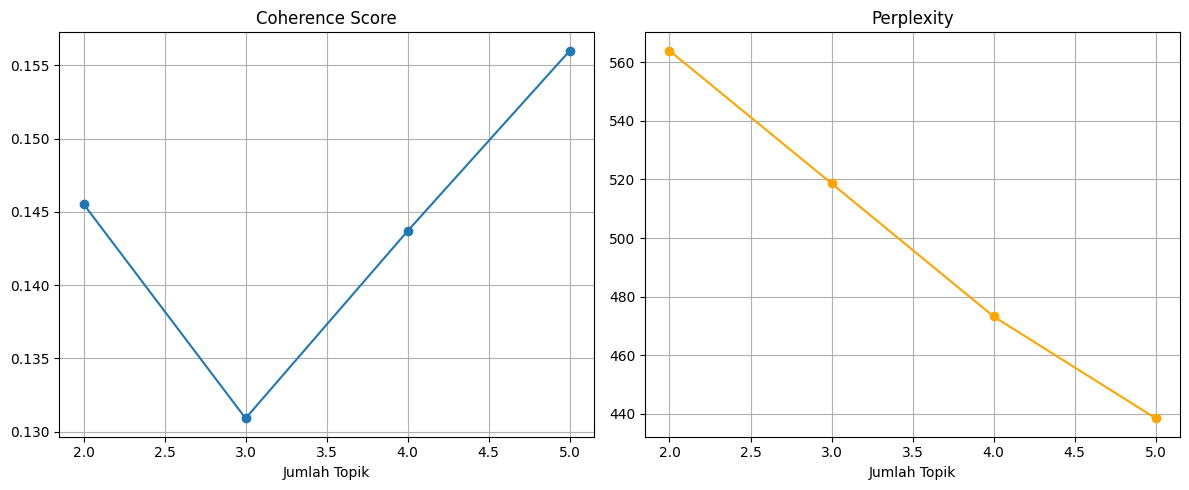


Jumlah topik optimal: 5

Topik yang ditemukan:
Topik #1: bagus, bintang, foto, add, iklan, video, sayang, mantap, adain, tidak
Topik #2: masuk, tidak, akun, nomor, ponsel, lama, mau, daftar, verifikasi, susah
Topik #3: error, pesan, tidak, kata, jelek, sandi, selalu, kirim, benar, sering
Topik #4: makin, facebook, tidak, lihat, buruk, sampah, uninstall, cari, sekarang, skrg
Topik #5: timeline, hilang, fitur, kembali, hapus, kecewa, story, tidak, guna, baru


In [8]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# StopWordRemoverFactory dihapus karena kita pakai list manual
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import warnings
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

warnings.filterwarnings('ignore')

# 1. DEFINISI KAMUS MANUAL (KONTROL PENUH DI SINI)
# ==============================================================================

# Definisikan kamus normalisasi (slang -> formal)
custom_normalization_dict = {
    # Singkatan umum
    "yg": "yang", "gak": "tidak", "ga": "tidak", "bgt": "banget",
    "dgn": "dengan", "tdk": "tidak", "jgn": "jangan", "krn": "karena",
    "utk": "untuk", "sdh": "sudah", "aja": "saja", "kalo": "kalau",
    "kln": "kalian", "sy": "saya", "aq": "aku", "km": "kamu",
    "gimana": "bagaimana", "knp": "kenapa", "bisa": "dapat",

    # Typo atau slang spesifik aplikasi
    "donlot": "unduh", "download": "unduh", "apk": "aplikasi",
    "app": "aplikasi", "eror": "error", "lemot": "lambat",
    "lag": "lambat", "bug": "kesalahan", "fix": "perbaiki",
    "update": "pembaruan", "updet": "pembaruan", "chat": "pesan",
    "notif": "notifikasi", "login": "masuk", "log in": "masuk",
    "sign in": "masuk", "out": "keluar", "telfon": "telepon",
    "call": "telepon", "vc": "panggilan video", "futu": "foto",
    "gak": "tidak", "ga": "tidak", "gk": "tidak", "tdk": "tidak", "enggak": "tidak",
    "nggak": "tidak", "kagak": "tidak",
    "gw": "saya", "gua": "saya", "aku": "saya", "sy": "saya", "gue": "saya",
    "lu": "kamu", "lo": "kamu", "km": "kamu", "kalian": "kamu",
    "yg": "yang", "kalo": "kalau", "klo": "kalau",
    "krn": "karena", "karna": "karena",
    "utk": "untuk", "untk": "untuk",
    "dgn": "dengan", "dlm": "dalam",
    "sdh": "sudah", "udh": "sudah", "udah": "sudah",
    "blm": "belum",
    "jg": "juga", "jga": "juga",
    "tp": "tetapi", "tapi": "tetapi",
    "aja": "saja", "aj": "saja",
    "bgt": "sangat", "banget": "sangat",
    "knp": "kenapa", "napa": "kenapa",
    "gmn": "bagaimana", "gimana": "bagaimana",
    "bs": "bisa", "bisaa": "bisa", "gabisa": "tidak bisa", "ga bisa": "tidak bisa",
    "trus": "terus", "trs": "terus",
    "jd": "jadi", "jdi": "jadi",
    "pdhl": "padahal",
    "bnyk": "banyak",
    "sm": "sama",
    "lbh": "lebih",
    "dr": "dari",
    "eror": "error", "erorr": "error", "errorr": "error",
    "apk": "aplikasi", "apps": "aplikasi", "aplikasine": "aplikasi",
    "hp": "ponsel", "handphone": "ponsel",
    "download": "unduh", "donlot": "unduh",
    "update": "pembaruan", "updet": "pembaruan",
    "login": "masuk", "log in": "masuk", "sign in": "masuk",
    "log out": "keluar",
    "notif": "notifikasi",
    "verif": "verifikasi",
    "no": "nomor", "nmr": "nomor",
    "pw": "kata sandi", "password": "kata sandi", "sandi": "kata sandi",
    "chat": "pesan", "chatting": "pesan",
    "call": "panggilan", "nelpon": "panggilan", "telfon": "panggilan",
    "voom": "timeline", "line voom": "timeline",
    "tolong": "mohon", "pls": "mohon", "please": "mohon", "plis": "mohon",
    "balikin": "kembalikan",
    "ilang": "hilang",
    "tau": "tahu",
    "liat": "lihat",
    "cuman": "hanya", "cuma": "hanya",
    "makasih": "terima kasih", "tq": "terima kasih",
    "mulu": "terus", "melulu": "terus",
    "bener": "benar",
    "sampe": "sampai",
    "kapan": "kapan",
    "kocakk": "kocak",
    "skrg": "sekarang"
}
}

# Definisikan stopwords (kata yang akan dibuang)
custom_stopwords_list = {
    # Kata hubung umum
    "yang", "dan", "di", "ke", "dari", "ini", "itu", "untuk", "pada",
    "adalah", "sebagai", "dengan", "karena", "jika", "namun", "tetapi",
    "atau", "serta", "oleh", "saat", "dalam", "bisa", "sudah", "ada",
    "akan", "apakah", "bagaimana", "kenapa", "siapa", "dimana",

    # Kata ganti orang (opsional, tergantung kebutuhan topik)
    "saya", "aku", "kamu", "dia", "mereka", "kita", "kami", "anda",

    # Kata umum yang tidak memberi makna sentimen/topik di konteks ini
    "line", "aplikasi", "nya", "sih", "dong", "deh", "kok", "mah",
    "tuh", "ya", "yah", "oh", "ok", "oke", "yaitu", "yakni", "sekali",
    "saja", "lagi", "pun", "masih", "belum", "juga", "buat", "pake",
    "pakai", "bikin", "biar", "terus", "jadi", "kan", "lah", "kah",
    "the", "and", "please", "to", "for", "is", "of", "in",
    "dan", "atau", "tetapi", "tapi", "juga",
    "yang", "di", "ke", "dari", "pada", "dalam", "untuk", "bagi", "kepada", "oleh",
    "ini", "itu", "tersebut", "disini", "disitu",
    "saya", "aku", "kamu", "dia", "mereka", "kita", "kami", "anda", "kalian",
    "bisa", "dapat", "akan", "sedang", "sudah", "telah", "masih", "belum",
    "ada", "adalah", "ialah", "merupakan", "sebagai", "seperti",
    "sih", "dong", "deh", "kok", "lah", "mah", "kan", "pun", "doang",
    "nya",
    "saja", "aja",
    "padahal", "walaupun", "meskipun",
    "karena", "sebab", "akibat", "sehingga", "maka",
    "terus", "lalu", "kemudian", "akhirnya",
    "sangat", "banget", "sekali", "terlalu",
    "mohon", "tolong", "harap", "silakan",
    "terima", "kasih", "makasih",
    "tanya", "tahu", "kasih", "banyak", "sedikit", "kurang", "lebih",
    "hari", "tanggal", "bulan", "tahun", "jam", "waktu",
    "kali", "tiap", "setiap",
    "apa", "kenapa", "bagaimana", "dimana", "siapa",
    "halo", "hai", "min", "admin", "kak", "gan", "sis", "bro", "loh"
}

# ==============================================================================

# Muat dataset
# Pastikan file csv ada di folder yang sama
try:
    df = pd.read_csv('line_reviews_labeled_with_confidence.csv')
    print(f"Data shape: {df.shape}")
except FileNotFoundError:
    # Contoh data dummy jika file tidak ditemukan (agar kode tetap jalan saat dicoba)
    print("File tidak ditemukan, menggunakan data dummy untuk demo.")
    data = {
        'content': [
            "Aplikasi line yg sekarang lemot bgt, gabisa dibuka",
            "Suka banget sama fiturnya, tapi notif sering telat",
            "Kenapa sih abis update malah jadi sering force close?",
            "Line bagus buat chat sama temen, stikernya lucu2",
            "Tolong perbaiki bug di panggilan video, suaranya putus2",
            "Gak bisa login padahal password udah bener",
            "Fitur baru nya membingungkan, balikin ke versi lama dong",
            "Unduh ulang tetep aja error, tolong di fix min",
            "Sering banget pending pesannya, padahal sinyal bagus",
            "Good application, sangat membantu komunikasi"
        ]
    }
    df = pd.DataFrame(data)

# Pastikan kolom konten tidak null dan berupa string
df = df.dropna(subset=['content'])
df['content'] = df['content'].astype(str)

def clean_text(text):
    """Membersihkan teks dari karakter khusus dan mengubah ke lowercase"""
    # Case folding
    text = text.lower()
    # Hapus karakter khusus, angka, dan emoji
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Hapus angka juga agar topik lebih bersih
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Tokenisasi awal
def tokenize_text(text):
    return text.split()

# Normalisasi kata gabungan dengan regex (Logika ini tetap dipertahankan)
def normalize_merged_words(tokens):
    """Menormalkan pola kata gabungan yang umum"""
    normalized_tokens = []
    for token in tokens:
        # Tangani pola "ga" + konsonan (contoh: gabisa -> tidak bisa)
        if re.match(r'\bga([bpmdtcjszkgfhv])', token):
            token = re.sub(r'\bga([bpmdtcjszkgfhv]\w*)', r'tidak \1', token)
            if ' ' in token:
                normalized_tokens.extend(token.split())
                continue
        # Tangani pola "ga" + vokal (contoh: gausah -> tidak usah)
        elif re.match(r'\bgau([a-z])', token):
            token = re.sub(r'\bgau([a-z]\w*)', r'tidak u\1', token)
            if ' ' in token:
                normalized_tokens.extend(token.split())
                continue
        normalized_tokens.append(token)
    return normalized_tokens

# Normalisasi token dengan dictionary MANUAL
def normalize_tokens(tokens):
    return [custom_normalization_dict.get(token, token) for token in tokens]

# Hapus stopwords dengan list MANUAL
def remove_stopwords(tokens):
    return [token for token in tokens if token not in custom_stopwords_list and len(token) > 1]

# Inisialisasi stemmer (Sastrawi tetap dipakai untuk stemming akar kata)
stemmer = StemmerFactory().create_stemmer()

def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

# Pipeline preprocessing lengkap
def preprocess_text(text):
    if pd.isna(text) or text == "":
        return []

    # 1. Cleaning
    cleaned = clean_text(text)
    # 2. Tokenisasi
    tokens = tokenize_text(cleaned)
    # 3. Normalisasi Regex (gabisa -> tidak bisa)
    tokens = normalize_merged_words(tokens)
    # 4. Normalisasi Dictionary (yg -> yang)
    tokens = normalize_tokens(tokens)
    # 5. Hapus Stopwords
    tokens = remove_stopwords(tokens)
    # 6. Stemming
    tokens = stem_tokens(tokens)
    # 7. Filter ulang token pendek setelah stemming (kadang stemming menghasilkan kata pendek)
    tokens = [token for token in tokens if
              len(token) > 2]

    return tokens

# Terapkan preprocessing
print("Melakukan preprocessing (ini mungkin memakan waktu)...")
df['tokens'] = df['content'].apply(preprocess_text)

# Hapus dokumen kosong
df = df[df['tokens'].apply(len) > 0]
print(f"Jumlah dokumen setelah preprocessing: {df.shape[0]}")

# Simpan teks untuk TF-IDF
df['preprocessed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

# --- BAGIAN PEMODELAN LDA ---

print("\nMembangun model TF-IDF dan LDA...")

# Count vectorizer untuk corpus asli (untuk perhitungan coherence)
count_vectorizer = CountVectorizer(
    min_df=2,              # Sesuaikan: minimal muncul di 2 dokumen
    max_df=0.9,            # Sesuaikan: maksimal di 90% dokumen
    ngram_range=(1, 1)     # Fokus unigram dulu agar topik lebih jelas
)

# Fit dan transform
count_matrix = count_vectorizer.fit_transform(df['preprocessed_text'])
corpus = count_matrix.toarray()
vocabulary = count_vectorizer.get_feature_names_out()
print(f"Dimensi corpus matrix: {corpus.shape}")

# Buat vectorizer TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.7,
    use_idf=True,
    sublinear_tf=True,
    ngram_range=(1, 1),
    norm=None,
    vocabulary=count_vectorizer.vocabulary_
)

tfidf_matrix = tfidf_vectorizer.fit_transform(df['preprocessed_text'])
print(f"Dimensi TF-IDF matrix: {tfidf_matrix.shape}")

# Implementasi C_V Coherence Score (Tetap sama)
def calculate_cv_coherence(topics, tokens_list, corpus, vocabulary):
    vocab_index = {word: idx for idx, word in enumerate(vocabulary)}
    topic_count = len(topics)
    total_coherence = 0

    word_doc_counts = defaultdict(set)
    for doc_idx, doc_tokens in enumerate(tokens_list):
        for token in set(doc_tokens):
            if token in vocab_index:
                word_doc_counts[token].add(doc_idx)

    num_docs = len(tokens_list)

    for topic_words in topics:
        valid_words = [w for w in topic_words if w in vocab_index]
        if len(valid_words) < 2:
            continue

        topic_coherence = 0
        pair_count = 0

        for i in range(len(valid_words)):
            for j in range(i+1, len(valid_words)):
                word_i = valid_words[i]
                word_j = valid_words[j]

                docs_i = word_doc_counts.get(word_i, set())
                docs_j = word_doc_counts.get(word_j, set())
                docs_both = docs_i.intersection(docs_j)

                n_i = len(docs_i)
                n_j = len(docs_j)
                n_both = len(docs_both)

                epsilon = 0.000001
                p_i = (n_i + epsilon) / num_docs
                p_j = (n_j + epsilon) / num_docs
                p_both = (n_both + epsilon) / num_docs

                pmi = np.log10(p_both / (p_i * p_j))
                if p_both > epsilon:
                    npmi = pmi / (-np.log10(p_both))
                    topic_coherence += npmi
                    pair_count += 1

        if pair_count > 0:
            avg_topic_coherence = topic_coherence / pair_count
            total_coherence += avg_topic_coherence

    if topic_count > 0:
        return total_coherence / topic_count
    else:
        return 0

# Evaluasi LDA
def evaluate_lda_models(tfidf_matrix, tokens_list, corpus, vocabulary, topic_nums=[3]):
    coherence_scores = []
    perplexity_scores = []

    for num_topics in topic_nums:
        print(f"Evaluasi model dengan {num_topics} topik...")

        lda_model = LatentDirichletAllocation(
            n_components=num_topics,
            learning_method='batch',
            random_state=42,
            max_iter=50, # Dikurangi untuk percobaan cepat
            doc_topic_prior=0.1,
            topic_word_prior=0.01
        )

        lda_model.fit(tfidf_matrix)
        perplexity = lda_model.perplexity(tfidf_matrix)
        perplexity_scores.append(perplexity)

        topics = []
        feature_names = tfidf_vectorizer.get_feature_names_out()
        for topic_idx, topic in enumerate(lda_model.components_):
            top_words_idx = topic.argsort()[:-11:-1]
            top_words = [feature_names[i] for i in top_words_idx]
            topics.append(top_words)

        coherence = calculate_cv_coherence(topics, tokens_list, corpus, vocabulary)
        coherence_scores.append(coherence)
        print(f"  - {num_topics} topik:")
        print(f"    Coherence (C_V) = {coherence:.4f}")
        print(f"    Perplexity     = {perplexity:.4f}")

    return topic_nums, coherence_scores, perplexity_scores

# Jalankan evaluasi
# Range topik disesuaikan lebih kecil untuk demo cepat, ubah range(...) jika data besar
topic_nums, coherence_scores, perplexity_scores = evaluate_lda_models(
    tfidf_matrix,
    df['tokens'].tolist(),
    corpus,
    vocabulary,
    topic_nums=range(2, 6)
)

# Plot hasil
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(topic_nums, coherence_scores, marker='o')
plt.title('Coherence Score')
plt.xlabel('Jumlah Topik')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(topic_nums, perplexity_scores, marker='o', color='orange')
plt.title('Perplexity')
plt.xlabel('Jumlah Topik')
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Final
optimal_num_topics = topic_nums[coherence_scores.index(max(coherence_scores))]
print(f"\nJumlah topik optimal: {optimal_num_topics}")

final_lda_model = LatentDirichletAllocation(
    n_components=optimal_num_topics,
    learning_method='online',
    random_state=42,
    max_iter=30
)
final_lda_model.fit(tfidf_matrix)

# Tampilkan Topik
print("\nTopik yang ditemukan:")
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(final_lda_model.components_):
    top_words_idx = topic.argsort()[:-11:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topik #{topic_idx+1}: {', '.join(top_words)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.2/555.2 kB 12.6 MB/s eta 0:00:00
Membuat WordCloud untuk setiap topik...


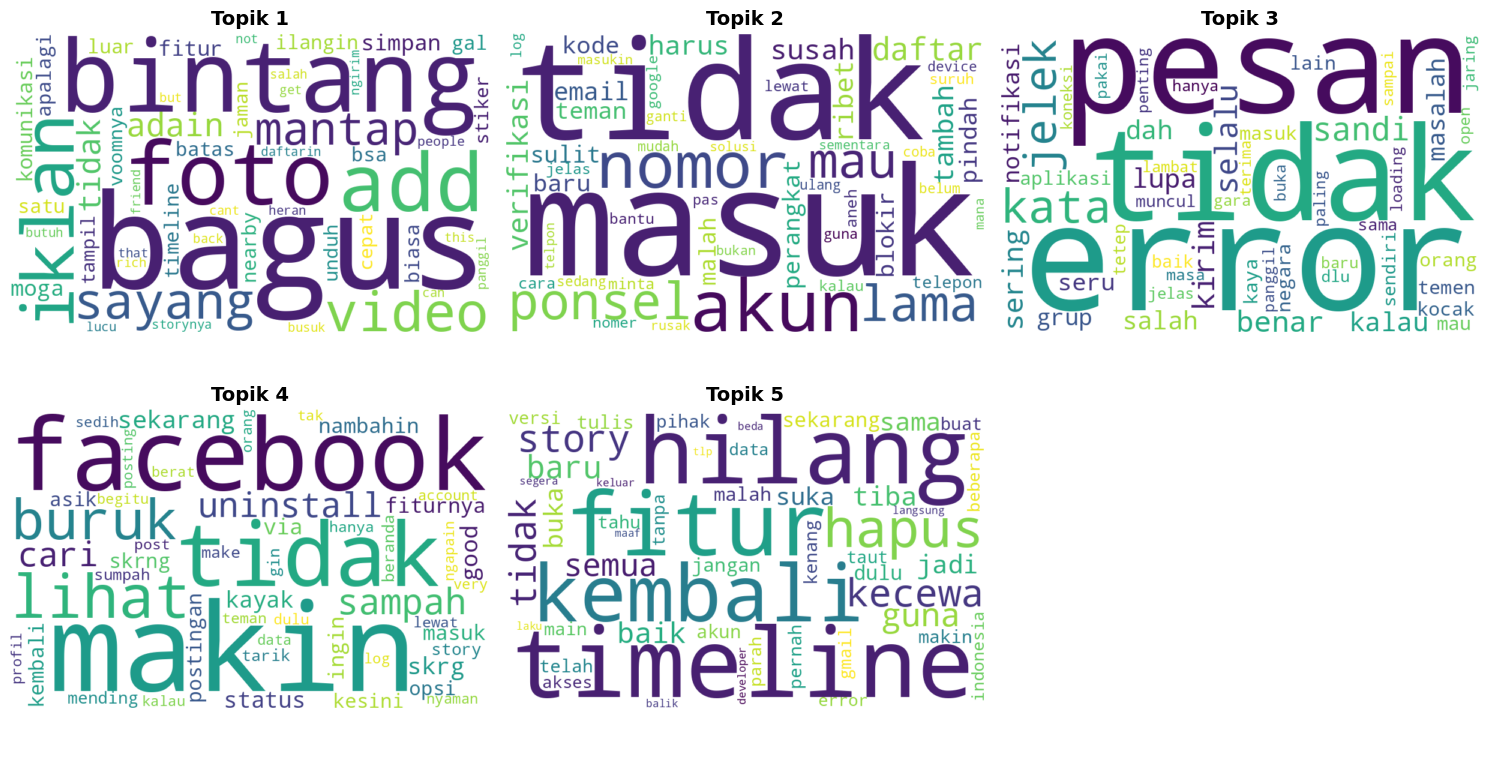

In [5]:
# Install wordcloud jika belum ada (hapus tanda pagar jika menggunakan Colab/Jupyter)
!pip install wordcloud

from wordcloud import WordCloud
import math

# 1. Konfigurasi Grid Plot
# Ambil model dan nama fitur dari proses sebelumnya
# Pastikan variabel 'lda_model' dan 'feature_names' sudah ada dari cell sebelumnya
n_topics = len(final_lda_model.components_)
n_cols = 3  # Jumlah kolom ke samping
n_rows = math.ceil(n_topics / n_cols)

# Buat canvas plot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

# 2. Loop untuk setiap topik
print("Membuat WordCloud untuk setiap topik...")

for topic_idx, topic in enumerate(final_lda_model.components_):
    # Ambil 50 kata teratas beserta bobotnya (frequency)
    top_indices = topic.argsort()[:-51:-1]
    top_words = [feature_names[i] for i in top_indices]
    top_weights = topic[top_indices]

    # Buat dictionary {kata: bobot} untuk WordCloud
    word_freq = dict(zip(top_words, top_weights))

    # Generate WordCloud
    wc = WordCloud(
        background_color='white',
        width=800,
        height=500,
        colormap='viridis', # Pilihan warna: 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
        random_state=42
    )
    wc.generate_from_frequencies(word_freq)

    # Tampilkan di subplot
    ax = axes[topic_idx]
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f'Topik {topic_idx + 1}', fontsize=14, fontweight='bold')
    ax.axis('off')

# Matikan sumbu untuk subplot yang kosong (jika ada)
for i in range(n_topics, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# ==============================================================================
# RETRAINING LDA DENGAN 3 TOPIK (GABUNGAN TOPIK 1 & 3)
# ==============================================================================

# 1. Update Stopwords
# Kita tambahkan kata-kata noise dari analisis sebelumnya agar topik gabungan lebih bersih
new_noise_words = {
    "this", "open", "via", "adain"
}
custom_stopwords_list.update(new_noise_words)

print("1. Membersihkan ulang data dari stopwords tambahan...")
# Fungsi cepat untuk memfilter token yang sudah ada tanpa preprocessing dari nol
df['tokens'] = df['tokens'].apply(lambda x: [w for w in x if w not in custom_stopwords_list])
df['text_clean'] = df['tokens'].apply(lambda x: ' '.join(x))

# 2. Re-Build TF-IDF Matrix (Penting karena data berubah)
print("2. Membangun ulang matriks TF-IDF...")
vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.7,
    use_idf=True,
    sublinear_tf=True,
    ngram_range=(1, 1),
    norm=None,
    vocabulary=count_vectorizer.vocabulary_
    )
tfidf_matrix = vectorizer.fit_transform(df['text_clean'])
feature_names = vectorizer.get_feature_names_out()

# 3. Latih LDA dengan 3 Topik
# Ini akan memaksa Topik 1 (Sentimen) dan Topik 3 (Campuran) melebur
print("3. Melatih Model LDA dengan 3 Topik...")
final_lda_3 = LatentDirichletAllocation(
       n_components=3, # Fixed: Changed num_topics to 3 as intended
       learning_method='batch',
       random_state=42,
       max_iter=50, # Dikurangi untuk percobaan cepat
       doc_topic_prior=0.1,
       topic_word_prior=0.01
)
final_lda_3.fit(tfidf_matrix)

# 4. Tampilkan Top Keyword
print("\n" + "="*40)
print("HASIL PENGGABUNGAN (3 TOPIK FINAL)")
print("="*40)

for idx, topic in enumerate(final_lda_3.components_):
    top_indices = topic.argsort()[:-16:-1] # Ambil top 15 kata
    top_words = [feature_names[i] for i in top_indices]

    # Print rapi
    print(f"\nTOPIK #{idx+1}")
    print(f"Top Keywords: {', '.join(top_words)}")

1. Membersihkan ulang data dari stopwords tambahan...
2. Membangun ulang matriks TF-IDF...
3. Melatih Model LDA dengan 3 Topik...

HASIL PENGGABUNGAN (3 TOPIK FINAL)

TOPIK #1
Top Keywords: pesan, tidak, sering, baik, buruk, notifikasi, error, buka, good, panggil, kirim, unduh, orang, tiba, mantap

TOPIK #2
Top Keywords: tidak, masuk, akun, nomor, mau, ponsel, lama, error, daftar, susah, verifikasi, baru, harus, tambah, ribet

TOPIK #3
Top Keywords: timeline, fitur, kembali, story, hapus, hilang, tidak, bagus, kecewa, makin, jelek, sekarang, dulu, semua, sama


Membuat visualisasi WordCloud untuk 3 Topik Final...


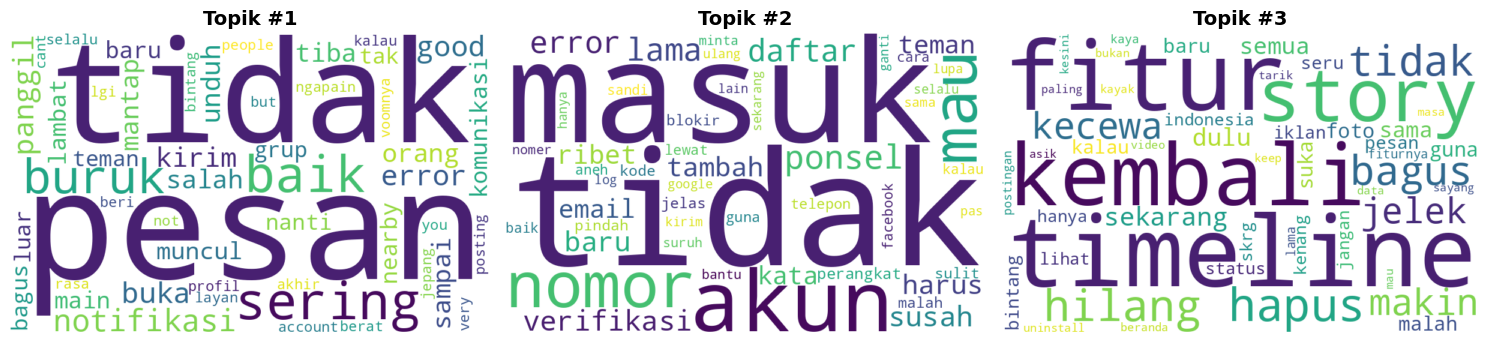

In [7]:
from wordcloud import WordCloud
import math

# ==============================================================================
# VISUALISASI WORDCLOUD (MODEL 3 TOPIK)
# ==============================================================================

# Pastikan menggunakan model dan feature names yang baru
lda_model = final_lda_3
feature_names = vectorizer.get_feature_names_out()

n_topics = 3
n_cols = 3
n_rows = 1

# Siapkan Canvas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5), sharex=True, sharey=True)
axes = axes.flatten()

print("Membuat visualisasi WordCloud untuk 3 Topik Final...")

for topic_idx, topic in enumerate(lda_model.components_):
    # Ambil 50 kata teratas berdasarkan bobot
    top_indices = topic.argsort()[:-51:-1]
    top_words = [feature_names[i] for i in top_indices]
    top_weights = topic[top_indices]

    # Buat dictionary frekuensi
    word_freq = dict(zip(top_words, top_weights))

    # Generate WordCloud
    wc = WordCloud(
        background_color='white',
        width=800,
        height=500,
        colormap='viridis', # Opsi warna: 'plasma', 'inferno', 'magma', 'cividis'
        random_state=42
    )
    wc.generate_from_frequencies(word_freq)

    # Tampilkan
    ax = axes[topic_idx]
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f'Topik #{topic_idx + 1}', fontsize=14, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# ==============================
# CELL 1: PREPROCESSING MODULE
# ==============================

# 1. DEFINISI KAMUS MANUAL (KONTROL PENUH DI SINI)
# ==============================================================================

# Definisikan kamus normalisasi (slang -> formal)
custom_normalization_dict = {
    # Singkatan umum
    "yg": "yang", "gak": "tidak", "ga": "tidak", "bgt": "banget",
    "dgn": "dengan", "tdk": "tidak", "jgn": "jangan", "krn": "karena",
    "utk": "untuk", "sdh": "sudah", "aja": "saja", "kalo": "kalau",
    "kln": "kalian", "sy": "saya", "aq": "aku", "km": "kamu",
    "gimana": "bagaimana", "knp": "kenapa", "bisa": "dapat",

    # Typo atau slang spesifik aplikasi
    "donlot": "unduh", "download": "unduh", "apk": "aplikasi",
    "app": "aplikasi", "eror": "error", "lemot": "lambat",
    "lag": "lambat", "bug": "kesalahan", "fix": "perbaiki",
    "update": "pembaruan", "updet": "pembaruan", "chat": "pesan",
    "notif": "notifikasi", "login": "masuk", "log in": "masuk",
    "sign in": "masuk", "out": "keluar", "telfon": "telepon",
    "call": "telepon", "vc": "panggilan video", "futu": "foto",
    "gak": "tidak", "ga": "tidak", "gk": "tidak", "tdk": "tidak", "enggak": "tidak",
    "nggak": "tidak", "kagak": "tidak",
    "gw": "saya", "gua": "saya", "aku": "saya", "sy": "saya", "gue": "saya",
    "lu": "kamu", "lo": "kamu", "km": "kamu", "kalian": "kamu",
    "yg": "yang", "kalo": "kalau", "klo": "kalau",
    "krn": "karena", "karna": "karena",
    "utk": "untuk", "untk": "untuk",
    "dgn": "dengan", "dlm": "dalam",
    "sdh": "sudah", "udh": "sudah", "udah": "sudah",
    "blm": "belum",
    "jg": "juga", "jga": "juga",
    "tp": "tetapi", "tapi": "tetapi",
    "aja": "saja", "aj": "saja",
    "bgt": "sangat", "banget": "sangat",
    "knp": "kenapa", "napa": "kenapa",
    "gmn": "bagaimana", "gimana": "bagaimana",
    "bs": "bisa", "bisaa": "bisa", "gabisa": "tidak bisa", "ga bisa": "tidak bisa",
    "trus": "terus", "trs": "terus",
    "jd": "jadi", "jdi": "jadi",
    "pdhl": "padahal",
    "bnyk": "banyak",
    "sm": "sama",
    "lbh": "lebih",
    "dr": "dari",
    "eror": "error", "erorr": "error", "errorr": "error",
    "apk": "aplikasi", "apps": "aplikasi", "aplikasine": "aplikasi",
    "hp": "ponsel", "handphone": "ponsel",
    "download": "unduh", "donlot": "unduh",
    "update": "pembaruan", "updet": "pembaruan",
    "login": "masuk", "log in": "masuk", "sign in": "masuk",
    "log out": "keluar",
    "notif": "notifikasi",
    "verif": "verifikasi",
    "no": "nomor", "nmr": "nomor",
    "pw": "kata sandi", "password": "kata sandi", "sandi": "kata sandi",
    "chat": "pesan", "chatting": "pesan",
    "call": "panggilan", "nelpon": "panggilan", "telfon": "panggilan",
    "voom": "timeline", "line voom": "timeline",
    "tolong": "mohon", "pls": "mohon", "please": "mohon", "plis": "mohon",
    "balikin": "kembalikan",
    "ilang": "hilang",
    "tau": "tahu",
    "liat": "lihat",
    "cuman": "hanya", "cuma": "hanya",
    "makasih": "terima kasih", "tq": "terima kasih",
    "mulu": "terus", "melulu": "terus",
    "bener": "benar",
    "sampe": "sampai",
    "kapan": "kapan",
    "kocakk": "kocak"
}

# Definisikan stopwords (kata yang akan dibuang)
custom_stopwords_list = {
    # Kata hubung umum
    "yang", "dan", "di", "ke", "dari", "ini", "itu", "untuk", "pada",
    "adalah", "sebagai", "dengan", "karena", "jika", "namun", "tetapi",
    "atau", "serta", "oleh", "saat", "dalam", "bisa", "sudah", "ada",
    "akan", "apakah", "bagaimana", "kenapa", "siapa", "dimana",

    # Kata ganti orang (opsional, tergantung kebutuhan topik)
    "saya", "aku", "kamu", "dia", "mereka", "kita", "kami", "anda",

    # Kata umum yang tidak memberi makna sentimen/topik di konteks ini
    "line", "aplikasi", "nya", "sih", "dong", "deh", "kok", "mah",
    "tuh", "ya", "yah", "oh", "ok", "oke", "yaitu", "yakni", "sekali",
    "saja", "lagi", "pun", "masih", "belum", "juga", "buat", "pake",
    "pakai", "bikin", "biar", "terus", "jadi", "kan", "lah", "kah",
    "the", "and", "please", "to", "for", "is", "of", "in",
    "dan", "atau", "tetapi", "tapi", "juga",
    "yang", "di", "ke", "dari", "pada", "dalam", "untuk", "bagi", "kepada", "oleh",
    "ini", "itu", "tersebut", "disini", "disitu",
    "saya", "aku", "kamu", "dia", "mereka", "kita", "kami", "anda", "kalian",
    "bisa", "dapat", "akan", "sedang", "sudah", "telah", "masih", "belum",
    "ada", "adalah", "ialah", "merupakan", "sebagai", "seperti",
    "sih", "dong", "deh", "kok", "lah", "mah", "kan", "pun", "doang",
    "nya",
    "saja", "aja",
    "padahal", "walaupun", "meskipun",
    "karena", "sebab", "akibat", "sehingga", "maka",
    "terus", "lalu", "kemudian", "akhirnya",
    "sangat", "banget", "sekali", "terlalu",
    "mohon", "tolong", "harap", "silakan",
    "terima", "kasih", "makasih",
    "tanya", "tahu", "kasih", "banyak", "sedikit", "kurang", "lebih",
    "hari", "tanggal", "bulan", "tahun", "jam", "waktu",
    "kali", "tiap", "setiap",
    "apa", "kenapa", "bagaimana", "dimana", "siapa",
    "halo", "hai", "min", "admin", "kak", "gan", "sis", "bro"
}

import re
import pandas as pd
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# ------------------------------
# LOAD DATASET
# ------------------------------
try:
    df = pd.read_csv("line_reviews_labeled_with_confidence.csv")
    print(f"Dataset loaded: {df.shape}")
except FileNotFoundError:
    print("File tidak ditemukan, pakai data dummy.")
    df = pd.DataFrame({
        "content": [
            "Aplikasi line yg sekarang lemot bgt, gabisa dibuka",
            "Suka banget sama fiturnya, tapi notif sering telat",
            "Kenapa abis update malah sering error",
            "Gak bisa login padahal password udah bener"
        ]
    })

df = df.dropna(subset=["content"])
df["content"] = df["content"].astype(str)

# ------------------------------
# PREPROCESSING FUNCTIONS
# ------------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_text(text):
    return text.split()

def normalize_merged_words(tokens):
    result = []
    for token in tokens:
        if re.match(r'\bga[a-z]+', token):
            token = re.sub(r'\bga([a-z]+)', r'tidak \1', token)
            result.extend(token.split())
        else:
            result.append(token)
    return result

def normalize_tokens(tokens, custom_normalization_dict):
    return [custom_normalization_dict.get(t, t) for t in tokens]

def remove_stopwords(tokens, custom_stopwords_list):
    return [t for t in tokens if t not in custom_stopwords_list and len(t) > 1]

stemmer = StemmerFactory().create_stemmer()

def stem_tokens(tokens):
    return [stemmer.stem(t) for t in tokens]

def preprocess_text(text, custom_normalization_dict, custom_stopwords_list):
    tokens = tokenize_text(clean_text(text))
    tokens = normalize_merged_words(tokens)
    tokens = normalize_tokens(tokens, custom_normalization_dict)
    tokens = remove_stopwords(tokens, custom_stopwords_list)
    tokens = stem_tokens(tokens)
    return [t for t in tokens if len(t) > 2]

# ------------------------------
# DEBUG FUNCTION (STEP BY STEP)
# ------------------------------
def debug_preprocessing(text, normalization_dict, stopwords):
    print("=== TEKS ASLI ===")
    print(text)

    step1 = clean_text(text)
    print("\n[1] Cleaning:", step1)

    step2 = tokenize_text(step1)
    print("\n[2] Tokenisasi:", step2)

    step3 = normalize_merged_words(step2)
    print("\n[3] Normalisasi Regex:", step3)

    step4 = normalize_tokens(step3, custom_stopwords_list)
    print("\n[4] Normalisasi Dictionary:", step4)

    step5 = remove_stopwords(step4, stopwords)
    print("\n[5] Stopword Removal:", step5)

    step6 = stem_tokens(step5)
    print("\n[6] Stemming:", step6)

    final = [t for t in step6 if len(t) > 2]
    print("\n[7] Final Tokens:", final)

    return final

# ------------------------------
# APPLY PREPROCESSING
# ------------------------------
df["tokens"] = df["content"].apply(
    lambda x: preprocess_text(x, custom_normalization_dict, custom_stopwords_list)
)

df = df[df["tokens"].apply(len) > 0]
df["preprocessed_text"] = df["tokens"].apply(lambda x: " ".join(x))

print(f"Dokumen setelah preprocessing: {df.shape[0]}")

Dataset loaded: (5323, 7)
Dokumen setelah preprocessing: 5169


In [9]:
# DEBUG SATU DOKUMEN
debug_preprocessing(
    df["content"].iloc[0],
    custom_normalization_dict,
    custom_stopwords_list
)


=== TEKS ASLI ===
Bagus untuk komunikasi

[1] Cleaning: bagus untuk komunikasi

[2] Tokenisasi: ['bagus', 'untuk', 'komunikasi']

[3] Normalisasi Regex: ['bagus', 'untuk', 'komunikasi']


TypeError: normalize_tokens() takes 1 positional argument but 2 were given